In [1]:
import os
# For data processing
import pandas as pd

# Matrix math
import numpy as np
import math

# For unnesting nested list/array
from itertools import chain

# Keras for deep learning
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LeakyReLU

# Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#for logging
import time
import datetime as dt

#plotting
import matplotlib.pyplot as plt

# Attempt to utilize GPU
import tensorflow as tf
from tensorflow.python.client import device_lib
from numba import cuda
from numba import *

import operator
from functools import reduce
import winsound

Using TensorFlow backend.
c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13372362857739343376
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6679640146
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8709825741773701734
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
df = pd.read_csv("Feat_Eng_A.csv", sep="\t", encoding='utf-8')
df.drop('Unnamed: 0', axis = 1, inplace=True)
# Drop Acorn as this can already be inferred
df.drop('Acorn', axis = 1, inplace=True)
# Remove dummy trap colums
trap_dummies = ['isNight', 'isWinter']
df.drop(trap_dummies, axis = 1, inplace = True)
# Drop variables due to missing data
df.drop('cloudCover',axis=1,inplace=True)
df.drop('dewPoint',axis=1,inplace=True)
df.drop('apparentTemperature',axis=1,inplace=True)
df.drop('visibility',axis=1,inplace=True)
df.drop('windSpeed',axis=1,inplace=True)
df.drop('windBearing',axis=1,inplace=True)
# Drop variables deemed irrelevant by statistical analysis
df.drop('pressure', axis=1, inplace=True)
# Sort values by smart meter
df = df[(df['Year'] < 2014) | ((df['Year'] == 2014) & (df['Month'] == 1) & (df['Day'] == 1) & (df['Hour'] < 1.5))]
df['LCLid'] = df['LCLid'].apply(str)
df = df[df['LCLid'] != '0']
df.reset_index(inplace=True, drop=True)

c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Define Functions

In [4]:
def normalize_df(merged_df):
    vals = merged_df.values
    # Save relevant columns to list
    ## Save ID by period
    ID = [vals[i,0] for i in range(len(vals))]
    ## Normalize quantitative variables
    humidity = [(vals[i,6] / vals[i,18])-1 for i in range(len(vals))]
    temperature = [(vals[i,7] / vals[i,19])-1 for i in range(len(vals))]
    KWH = [(vals[i,16]) for i in range(len(vals))]
    ## Save Binaries
    StdorToU = [vals[i,8] for i in range(len(vals))]
    isAutumn = [vals[i,9] for i in range(len(vals))]
    isSpring = [vals[i,10] for i in range(len(vals))]
    isSummer = [vals[i,11] for i in range(len(vals))]
    isHoliday = [vals[i,12] for i in range(len(vals))]
    isEvening = [vals[i,13] for i in range(len(vals))]
    isMorning = [vals[i,14] for i in range(len(vals))]
    isWeekend = [vals[i,15] for i in range(len(vals))]
    # Save normalization factors to list
    y_Normalization_Factors = [vals[i,20] for i in range(len(vals))]
    cols = ['LCLid','humidity','Temperature', 'StdorToU', 'isAutumn', 'isSpring', 'isSummer', 'isHoliday', 
            'isEvening', 'isMorning', 'isWeekend', 'KWH_hh']
    new_df = pd.DataFrame(np.column_stack([ID, humidity, temperature, StdorToU, isAutumn, isSpring, 
                                           isSummer, isHoliday, isEvening, isMorning, isWeekend,
                                           KWH]), columns=cols).values
    factors = y_Normalization_Factors
    return new_df, factors #, ID

In [5]:
def feature_scaling(sm):
    # Create period columns from MACID, Year, Month, Day, Evening,Morning,Night Dummies
    sm["period"] = (sm.loc[:,"LCLid"].map(str) + sm.loc[:,"Year"].map(str) + sm.loc[:,"Month"].map(str) + sm.loc[:,"Day"].map(str) + sm.loc[:,"isEvening"].map(str) + sm.loc[:,"isMorning"].map(str))
    # create aggregated object by 'period' 
    sm_ID_agg = sm.groupby('period')
    # Extract mean from aggregated list
    sm_aggregated_mean = sm_ID_agg.aggregate(np.mean)
    list_ = ['Year', 'Month', 'Day', 'Hour', 'StdorToU', 'isAutumn',
           'isSpring', 'isSummer', 'isHoliday', 'isEvening', 'isMorning',
           'isWeekend']
    sm_aggregated_mean.drop(list_, axis = 1, inplace = True)
    # Merge sm with mean values on period IDs
    normalization_df = pd.merge(sm, sm_aggregated_mean, how="outer", on="period")
    # Normalize df, return normalizeD df and normalization factors
    raw_data, normalization_factors = normalize_df(normalization_df)
    return raw_data, list(sm["DateTime"])

In [6]:
def model_data(raw_data, timestamps, days):
    # Amount of data that is used for training prediction
    sequence_length = days*48
    # Number of ending, up to, index for testing
    window_length = sequence_length+48
    #Convert the file to a list
    data = np.array(raw_data.tolist())  
    X_train = data[0:sequence_length, 0:len(data[0])-1]
    y_train = data[0:sequence_length, len(data[0])-1]
    X_test = data[sequence_length:window_length, 0:len(data[0])-1]
    y_test = data[sequence_length:window_length,len(data[0])-1]
    timestamps_test = timestamps[sequence_length:window_length]
    return X_train, y_train, X_test, y_test, timestamps_test

In [7]:
def initialize_model(X_train, loss_function, optimizer):
    #Create a Sequential model using Keras
    model = Sequential()
    #First MLP layer
    model.add(Dense(11,input_shape=(X_train.shape[1],)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    #Second MLP layer
    model.add(Dense(11))
    model.add(LeakyReLU(alpha=0.2))
    #Output layer (returns the predicted value)
    model.add(Dense(1, activation='relu'))
    model.add(LeakyReLU(alpha=0.3))
    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    return model

In [8]:
def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    #Train the model on X_train and Y_train
    with tf.device('/device:GPU:0'):
        model.fit(X_train, Y_train, batch_size= batch_num, epochs=num_epoch, validation_split= val_split, verbose = 0)
    return model

In [9]:
def test_model(model, X_test):
    #Test the model on X_Test
    with tf.device('/device:GPU:0'):
        y_predict = model.predict(X_test)
    return y_predict

In [10]:
def predict_365(df, meter, train_days, test_days):
    sm = df[df.LCLid == meter]
    sm, timestamps = feature_scaling(sm)
    sm = sm[:,1:]
    # Initialize predictions list
    predictions = []
    #Record the time the model starts training
    start = time.time()
    # Initialize iteration value
    i = 0
    while i < test_days:
        X_train, y_train, X_test, y_test, timestamps_test = model_data(sm, timestamps, train_days)
        model = initialize_model(X_train, loss_function='mean_squared_error', optimizer='adam')
        model = fit_model(model, X_train, y_train, batch_num = 256, num_epoch = 35, val_split = .3)
        y_predict = test_model(model, X_test)
        for x in range(len(y_predict)):
            predictions.append([y_predict[x][0], y_test[x], timestamps_test[x], meter])
        sm = sm[48:,:]
        timestamps = timestamps[48:]
        if i % 30 == 0:
            print('Epoch: ',i)
        i += 1
    proc_time = int(math.floor(time.time() - start))
    print('Predictions for ',meter,' takes ', proc_time, ' seconds, for ', i, ' days.')
    ## Merge Data
    predictions = np.array(predictions)
    pred_all = pd.DataFrame({'LCLid': predictions[:,3], 'DateTime': predictions[:,2], 'y_test': predictions[:,1], 
                             'y_hat':predictions[:,0]})  
    pred_all.to_csv((meter+".csv"), sep="\t", encoding='utf-8')
    return pred_all

In [11]:
def calculate_statistics(y_predict, Y_test):
    #Get Mean Squared Error
    RMSE = math.sqrt(mean_squared_error(y_predict.flatten(), Y_test.flatten()))
    # Get Mean Absolute Error
    MAE = mean_absolute_error(y_predict.flatten(), Y_test.flatten())
    # Get Pearson product-moment correlation coefficients
    corr = np.corrcoef(y_predict, Y_test)[1][0]**2
    return RMSE, MAE, corr

## Putting it together

### Step 1. Data Engineering

In [12]:
df.head()

,LCLid,Year,Month,Day,Hour,DateTime,humidity,temperature,StdorToU,isAutumn,isSpring,isSummer,isHoliday,isEvening,isMorning,isWeekend,KWH_hh
0,MAC000323,2012,12,1,0.0,2012-12-01 00:00,0.934,-0.284444,1,0,0,0,0,0,0,1,0.448
1,MAC001528,2012,12,1,0.0,2012-12-01 00:00,0.934,-0.284444,1,0,0,0,0,0,0,1,0.157
2,MAC001710,2012,12,1,0.0,2012-12-01 00:00,0.934,-0.284444,1,0,0,0,0,0,0,1,0.257
3,MAC001819,2012,12,1,0.0,2012-12-01 00:00,0.934,-0.284444,1,0,0,0,0,0,0,1,0.344
4,MAC002563,2012,12,1,0.0,2012-12-01 00:00,0.934,-0.284444,1,0,0,0,0,0,0,1,0.181


In [13]:
smart_meters = list(set(df.values[:,0]))

## Predictions

## Looping throughout the year

In [14]:
smart_meters[14]

'MAC005042'

In [15]:
ep = 15
print("We're at iteration " + str(ep) + ' for smart meter: ' + smart_meters[ep] + ", last iteration is at iteration " + str(len(smart_meters)-1))
rand_sm_pred = predict_365(df, smart_meters[ep], train_days = 31, test_days=365)
rand_sm_pred.y_hat = rand_sm_pred.y_hat.astype(float)
rand_sm_pred.y_test = rand_sm_pred.y_test.astype(float)

We're at iteration 15 for smart meter: MAC000323, last iteration is at iteration 23


c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:  0
Epoch:  30
Epoch:  60
Epoch:  90
Epoch:  120
Epoch:  150
Epoch:  180
Epoch:  210
Epoch:  240
Epoch:  270
Epoch:  300
Epoch:  330
Epoch:  360
Predictions for  MAC000323  takes  4185  seconds, for  365  days.


In [16]:
rand_sm_pred_RMSE, rand_sm_pred_MAE, rand_sm_corr = calculate_statistics(rand_sm_pred.y_test.values, rand_sm_pred.y_hat.values)
print("Root Mean Squared Error:", rand_sm_pred_RMSE)
print("Mean Absolute Error:", rand_sm_pred_MAE)
print("Correlation:", rand_sm_corr)

Root Mean Squared Error: 0.37354272667545796
Mean Absolute Error: 0.25878253567884246
Correlation: 0.027978717372440346


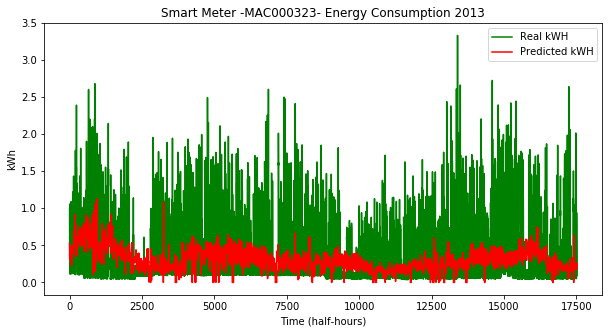

In [17]:
#Plot of the predicted prices versus the real prices
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Smart Meter -" +smart_meters[ep]+"- Energy Consumption 2013")
plt.plot(rand_sm_pred.y_test.values, color = 'green', label = 'Real kWH')
plt.plot(rand_sm_pred.y_hat.values, color = 'red', label = 'Predicted kWH')
ax.set_ylabel("kWh")
ax.set_xlabel("Time (half-hours)")
ax.legend()

In [18]:
frequency = 800  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)